In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
from __future__ import division
import numpy as np
from scipy import stats
import caffe
from augmentImages import process_img
from utils import files_list
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
caffe.set_device(0)
caffe.set_mode_gpu()

In [ ]:
im = caffe.io.load_image("/home/ubuntu/dataset/200_val/2/9952_left.jpeg")
plt.imshow(im);

## Preprocess test images and make predictions on 5 randomly rotated images 

In [4]:
model_path = "/home/ubuntu/digits-server/digits/digits/jobs/20151216-183415-a343/snapshot_iter_26310.caffemodel"
proto_path = "/home/ubuntu/digits-server/digits/digits/jobs/20151216-183415-a343/deploy.prototxt"
mean_path = "/home/ubuntu/digits-server/digits/digits/jobs/20151216-180534-3e3b/mean.jpg"
test_path = "/home/ubuntu/dataset/test/test/"
job_id = model_path.split('/')[-2]

In [5]:
net = caffe.Net(proto_path, model_path, caffe.TEST)

In [6]:
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_mean('data', caffe.io.load_image(mean_path).mean(0).mean(0))
transformer.set_transpose('data', (2,0,1))
transformer.set_channel_swap('data', (2,1,0))
transformer.set_raw_scale('data', 255.0)

In [ ]:
net.blobs['data'].data[:] = np.asarray([transformer.preprocess('data', im), transformer.preprocess('data', im)])
out = net.forward()
print("Predicted class is #{}.".format(out['prob'].argmax(1)))

In [34]:
def key_names(f1):
    return int(f1[0].split('/')[-1].split('_')[0])

In [37]:
names = sorted(files_list(test_path, "test"), key=key_names)
num_files = len(names)
print "Total number of test files: %d" % num_files

Total number of test files: 53576


In [8]:
scale = 180
crop_shape = (255, 255)
random_draws = 4
batch_size = 40
uniq_im_per_batch = batch_size // (random_draws + 1)

In [41]:
with Parallel(n_jobs=8) as parallel:
    for i in xrange(0, num_files, uniq_im_per_batch):
        upper_idx = min(i + uniq_im_per_batch, num_files)
        files_batch = names[i:upper_idx]
        num_uniq_im = (upper_idx - i)
        ret = parallel(delayed(process_img)(fname_lab, crop_shape, scale, random_draws, "test", False) 
                       for fname_lab in files_batch)
        ret = np.asarray(ret).reshape((num_uniq_im * (random_draws + 1), crop_shape[0], crop_shape[0], 3))
        if ret.shape[0] < batch_size:
            pad = np.zeros((batch_size - num_uniq_im, crop_shape[0], crop_shape[0], 3), dtype=ret.dtype)
            ret = np.vstack((ret, pad))
        assert ret.shape[0] == batch_size, ("Error: the input batch has lesser number"
                                            " of images than the expected batch size %d" % (batch_size))
        l = []
        for j in range(batch_size):
            l.append(transformer.preprocess('data', ret[j,:,:,:]))
        net.blobs['data'].data[:] = np.asarray(l)
        out = net.forward()
        preds = np.asarray(out['prob'][:num_uniq_im * (random_draws + 1), :].argmax(1))
        preds_im = stats.mode(preds.reshape((num_uniq_im, (random_draws + 1))), axis=1)[0]
        for j in range(num_uniq_im):
            print "%s,%d" % (files_batch[j][0].split('/')[-1].split('.')[0], preds_im[j])
        break

1_right,1
1_left,1
2_left,1
2_right,1
3_left,1
3_right,1
4_right,1
4_left,1


In [52]:
im = caffe.io.load_image("/home/ubuntu/dataset/test/test/27096_right.jpeg")

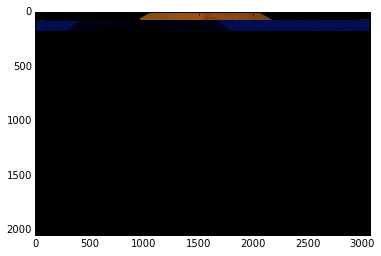

In [53]:
plt.imshow(im);